# Registration of LA-ICP-MS and MALDI-MS images

In [1]:
import sys
sys.path.append("../") # go to parent dir

from Reg_Code import *

## Parsing of MALDI-MS data

The following lines of code parse the MALDI-MS data for a given analysis, using an .imzML MALDI imaging file as input

* filename = string, name of the folder that includes the .imzML MALDI-MS raw data file
* peak_1 = float, peak appearing in the target tissue section
* tol_1 = integer, tolerance of peak_1

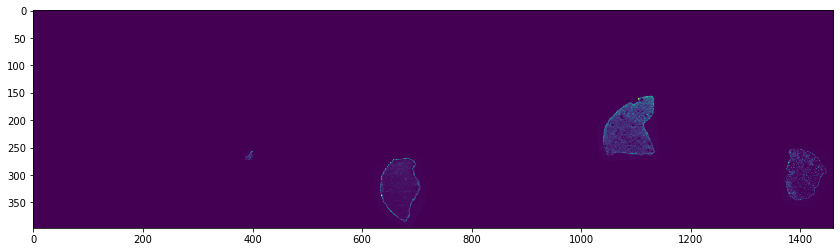

In [4]:
filename = 'inputs/Liver_tissue.imzML' 
peak_1 = 339.088 
tol_1 = 0.286

# MALDI-MS slide data parsing
slide, peak_1, tol_1 = parsing(filename, peak_1, tol_1)

## Cropping and Rotation of MALDI-MS data

Cropping and rotation of the MALDI-MS data

* X1, X2 = integers, range in the X axis in which the target tissue is located
* Y1, Y2 = integers, range in the Y axis in which the target tissue is located
* degree_rotation = Degree of rotation for the target tissue

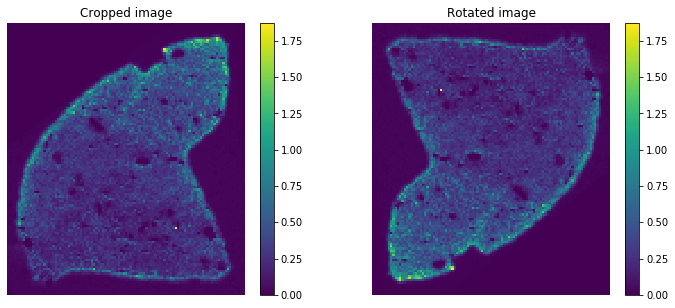

In [7]:
X1, X2 = 1035, 1140
Y1, Y2 = 150, 270
degree_rotation = 180

# MALDI pre-processing (Cropping and Rotation)
MALDI_rot, degree_rotation, X1, X2, Y1, Y2 = tissue_crop_rot(X1, X2, Y1, Y2, degree_rotation, slide, peak_1, tol_1)

## Hotspot Removal

Signal outliers that cause hot spots in the image are removed. MALDI images and box and whisker plots before and after hotspot removal are shown.

* quantile = float, number between 0 and 1 that corresponds to the quantile range that will be removed from the data. By default this value is set to 0.99

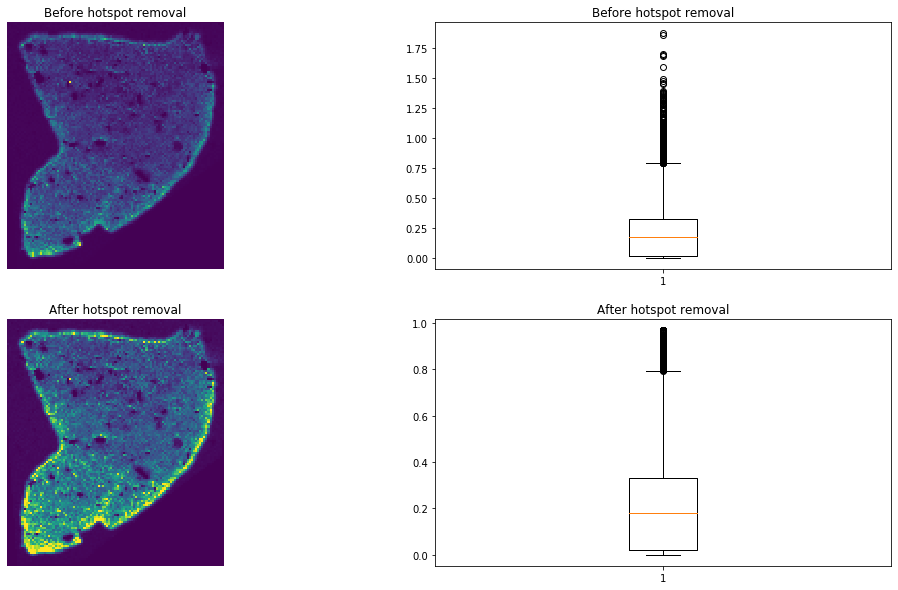

In [8]:
quantile = 0.99
MALDI_input = MALDI_rot

# Function to obtain hotspot removal conditions
hotspot_removal_conditions(quantile, MALDI_input)

## MALDI image processing and rendering

Hotspots are removed and MALDI images are rendered for measured m/z ratios that are provided in a .csv list of signals

* quantile_MALDI = float, number between 0 and 1 that corresponds to the quantile range that will be removed from the data. By default this value is set to 0.99.
* Signal_list = string, file location and name of the csv file containing the list of MALDI signals and its tolerances
* image_columns_MALDI = integer, number of columns in the final multi-image plot

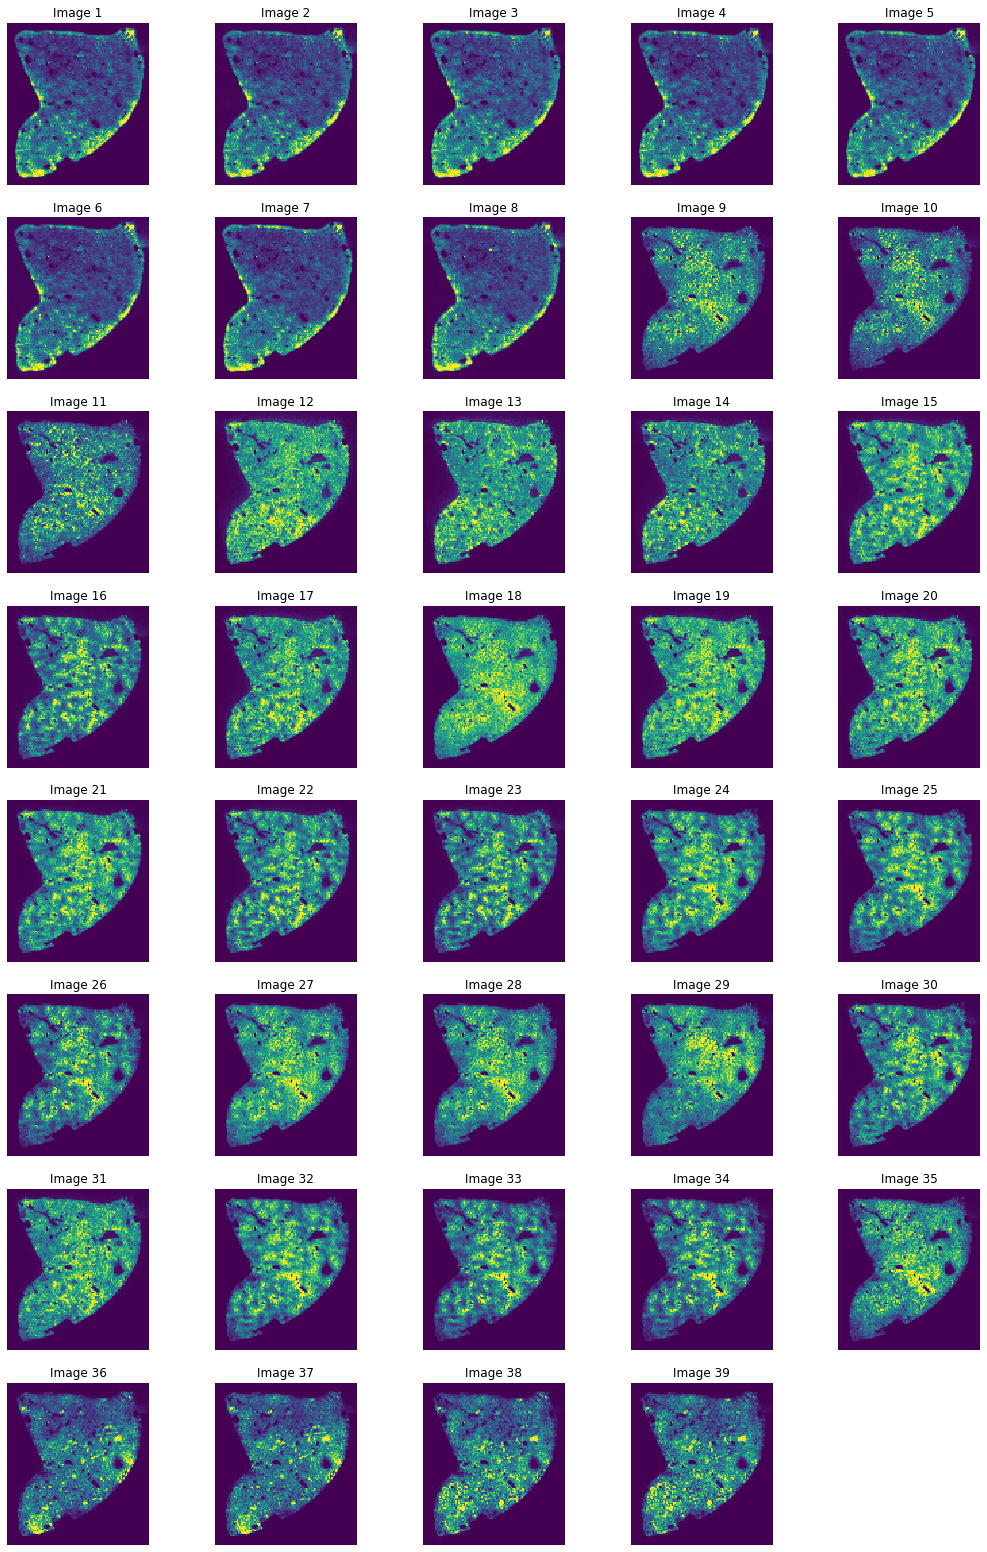

In [9]:
quantile_MALDI = 0.99
signal_list = 'inputs/MALDI_Signal_List.csv'
image_columns_MALDI = 5

# MALDI image processing with hotspot removal
images_MALDI, Ions = MALDI_rendering(signal_list, slide, degree_rotation, quantile_MALDI, X1, X2, Y1, Y2)

# MALDI image rendering
images_plot(images_MALDI, image_columns_MALDI)

## t-SNE dimensionality reduction

Reduce MALDI image dataset to one image for segmentation and registration input

* BM_MALDI_path = string, location and filename of the .csv file containing the background mask of the MALDI tissue 

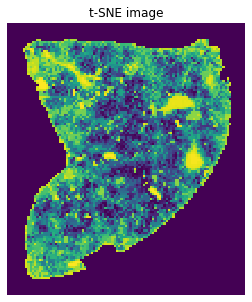

In [10]:
BM_MALDI_path = 'inputs/MALDI_BM.csv'

# Perform t-SNE
tsne_MALDI, BM_MALDI = tsne(BM_MALDI_path, images_MALDI)

## LA-ICP image processing and rendering

Hotspot removal, processing, and rendering of LA-ICP-MA images. Images are saved in a folder, and they are read using natural sorting of the files in the folder

* foldername_LA = string, file location and name of file containing the LA-ICP-MS images
* extension = string, extension of the LA-ICP-MS image files
* quantile_LA = float, number between 0 and 1 that corresponds to the quantile range that will be removed from the LA-ICP-MS data. By default this value is set to 0.99.
* BM_LA_path = string, location and filename of the .csv file containing the background mask of the LA-ICP-MS tissue 
* image_columns_LA = integer, number of columns in the final LA-ICP-MS multi-image plot

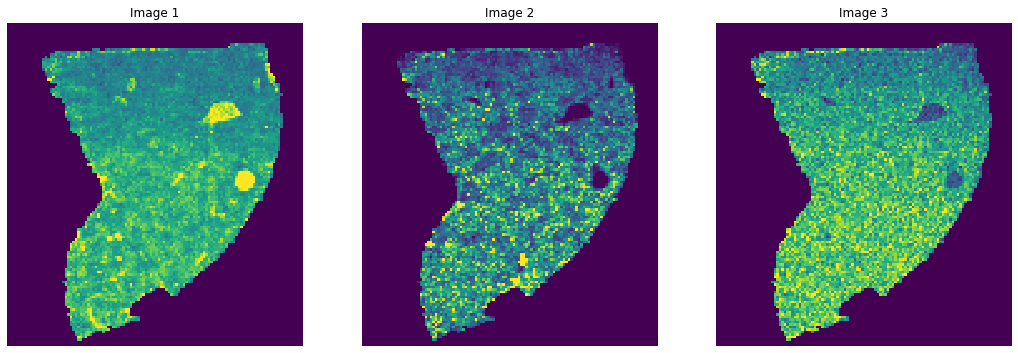

In [12]:
foldername_LA = '../example/inputs/LA_ICP_Images/'
extension = '*.xl'
quantile_LA = 0.99
BM_LA_path = 'inputs/LA_Background_Mask.csv'
image_columns_LA = 3

# Read LA-ICP images
images_LA = LA_process(foldername_LA, extension)

# Process LA-ICP images by hotspot removal
images_processed_LA, BM_LA = hotspot_removal(images_LA, quantile, BM_LA_path)

# MALDI image rendering
images_plot(images_processed_LA, image_columns_LA)

## Registration of MALDI-MS and LA-ICP-MS images

function to perform registration of LA-ICP-MS and MALDI-MS images

* fixed_image = 2D matrix, input image that will be set as the fixed image. In this example, we use the image obtained from t-SNE dimensionality reduction (tSNE_MALDI)
* moving_image = 2D matrix, input image that will be set as the fixed image. In this example we used the Fe image from the LA-ICP-MS image processing and rendering dataset (images_processed_LA), the index [0], corresponds to the first image in the dataset, that is the Fe image
* parameter_map = string, name of the default parameter in sitk that will be used for registration, we set it as affine in the example, but the following parameter maps can be used: translation, rigid, affine and b-spline.

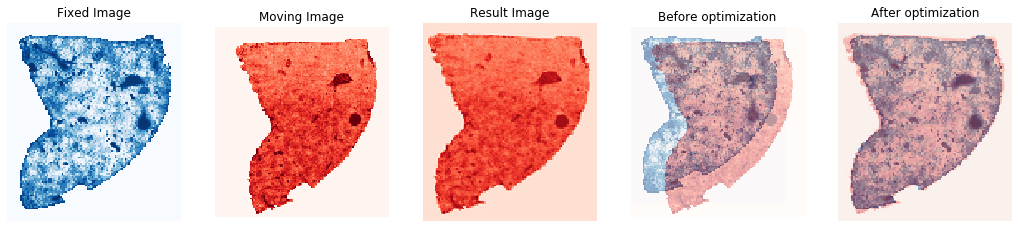

In [13]:
fixed_image = tsne_MALDI
moving_image = images_processed_LA[0]
parameter_map = 'affine'

# Perform registration of MALDI and LA images
ResultArray, FixedArray, MovingArray, TransParameterMap = registration(fixed_image, moving_image, parameter_map)

# Generate registration images
registration_plot(ResultArray, FixedArray, MovingArray)

## Transformation of LA-ICP signals into the MALDI-MS coordinate system

The LA-ICP-MS moving image is transformed into the MALDI-MS fixed image coordinate system

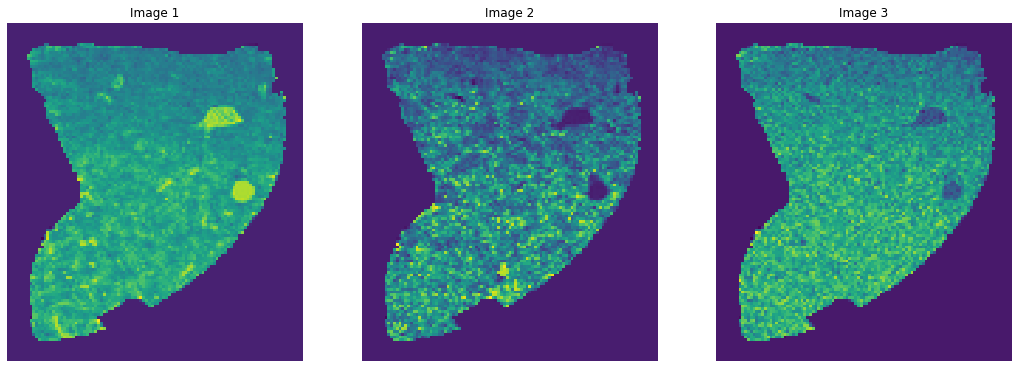

In [14]:
# Transformation of moving image channels
transformed_images_LA = transformation(images_processed_LA, BM_MALDI, TransParameterMap)

# Plot of transformed images
images_plot(transformed_images_LA, image_columns_LA)

## Calculation of correlation coefficients

Function to calculate and plot Pearson's correlation coefficients of registered LA-ICP-MS and MALDI-MS data.

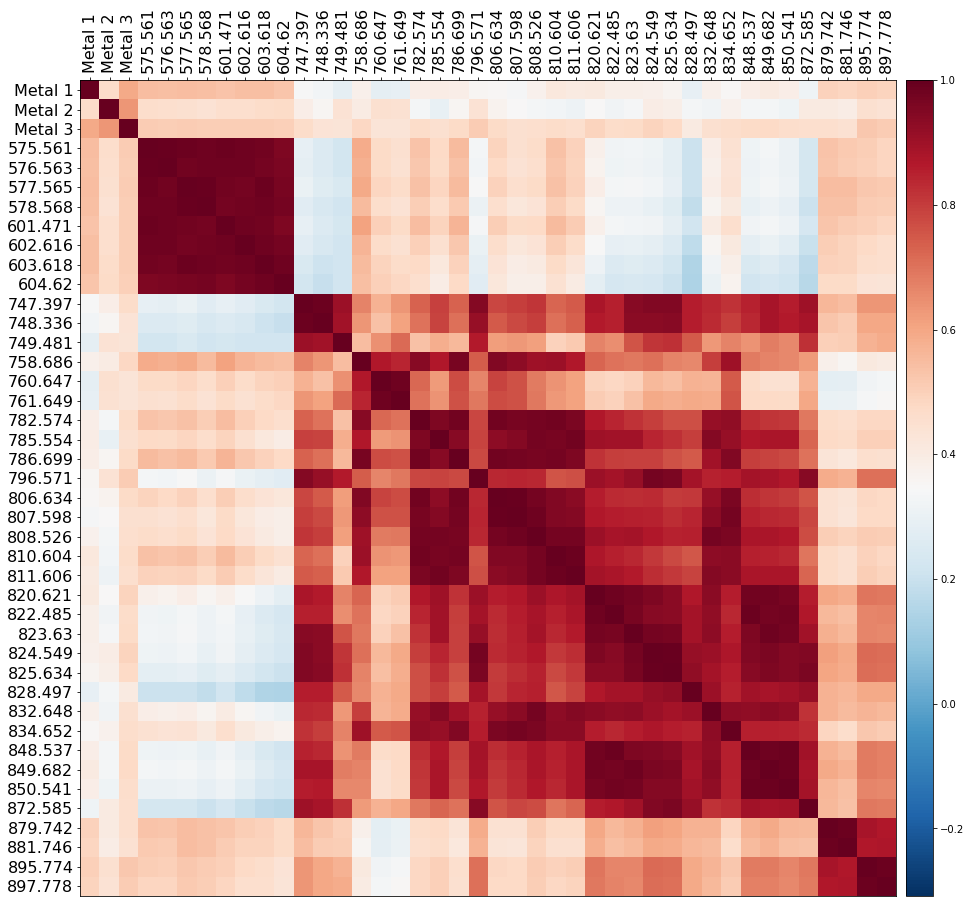

In [15]:
# Calculation of correlation coefficient matrix
corr_matrix = correlation_coefficient(images_MALDI, transformed_images_LA, BM_MALDI)

# Correlation coefficient plot
corr_plot(corr_matrix, Ions)